## Dependencies

# NeuralSymbolic - Demo

In [1]:
!pip3 install keras-rectified-adam
!pip3 install ann_visualizer
!pip3 install graphviz
!pip3 install tf-explain
!pip3 install opencv-python

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


In [3]:
!rm -rf ./logs/ 

In [4]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, KFold
import tensorflow as tf
import keras
import datetime
from tf_explain.core.grad_cam import GradCAM
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.losses import binary_crossentropy
from keras.utils  import plot_model
from keras_radam.training import RAdamOptimizer
from keras_radam import RAdam
import matplotlib.pyplot as plt
import warnings
import dalex as dx
warnings.filterwarnings('ignore')

In [5]:
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session


session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## GET data

In [6]:
# path to trains-transformed.csv
path = 'trains-transformed.csv'
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(path=path):
  df = pd.read_csv(path, ',')

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

df = read_data()
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,0


## Question 1.

Implemente uma solução que implemente proposicionalização com 32 features
de entrada, 9 perseptrons e uma única saída (denotando leste). As entradas codi=icam:

In [7]:
# get data
df = read_data()
Y = (np.array(df.pop('Class_attribute')))
X = (np.array(df))

### Akin Propositionalization Model

In [8]:
# define model
def model_v1():
  model = Sequential([
    Dense(9, activation='relu', input_shape=(len(df.keys()),)),
    Dense(1, activation='sigmoid'),
  ])
  model.compile(
    loss = binary_crossentropy, 
    optimizer = RAdamOptimizer(name='RAdam'),
    metrics = ['mse', 'binary_accuracy']
  ) 
  return model

es = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1000, verbose=0)

model = model_v1()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 297       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


In [9]:
plot_model(model, show_shapes=True, show_layer_names=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Train

In [10]:
# train
loo = LeaveOneOut()
hists = dict()
q1_names =  [
  'Train', 
  'Output of flat network', 
  ' Desired output', 
  'Class'
]
log_dir = "./" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
q1 = {name: [] for name in q1_names}

for i, (train, test) in tqdm.tqdm(enumerate(loo.split(X)), total=10):
  x_train = X[train]
  y_train = Y[train]
  x_test  = X[test]
  y_test  = Y[test] 

  model = model_v1()
  hist = model.fit(
    x_train.astype('int64'),
    y_train.astype('int64'),
    validation_data=(x_test.astype('int64'), y_test.astype('int64')),
    epochs=500,
    verbose=0,
    callbacks=[tensorboard_callback]
  )
  hists[test[0]] = hist
  q1['Train'].append(i)
  q1['Output of flat network'].append(model.predict(x_test.astype('int64'))[0][0])
  q1[' Desired output'].append(y_test[0])
  q1['Class'].append(str_att['Class_attribute'][int(y_test)])

100%|██████████| 10/10 [08:37<00:00, 51.75s/it]


In [11]:
%tensorboard --logdir "./"

### Results

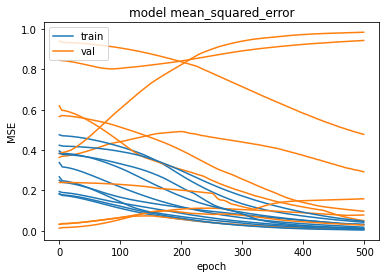

In [12]:
for i,history in enumerate(hists.values()):
  plt.plot(history.history['mse'], c='tab:blue')
  plt.plot(history.history['val_mse'], c='tab:orange')
  
plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

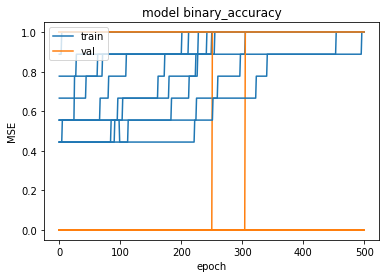

In [13]:
for i,history in enumerate(hists.values()):
  plt.plot(history.history['binary_accuracy'], c='tab:blue')
  plt.plot(history.history['val_binary_accuracy'], c='tab:orange')
  
plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
t1 = pd.DataFrame.from_dict(q1).round(2)

In [ ]:
ndf = read_date()

In [15]:
explainer = dx.Explainer(model, X.astype('int64'), Y.astype('int64'), label='PLOTADO')

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 10 rows 32 cols
  -> target variable   : 10 values
  -> model_class       : tensorflow.python.keras.engine.sequential.Sequential (default)
  -> label             : PLOTADO
  -> predict function  : <function yhat_tf_regression at 0x7f7bfe4d4af0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0112, mean = 0.528, max = 0.929
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.398, mean = -0.0277, max = 0.136
  -> model_info        : package tensorflow

A new explainer has been created!


In [16]:
explainer.model_performance()

,mse,rmse,r2,mae,mad
PLOTADO,0.026942,0.164142,0.89223,0.121942,0.081775


In [17]:
explainer.model_parts().plot()

## Question 2.

Implemente uma solução com base no modelo de aprendizado relacional contendo meta-redes para conectar conceitos das premissas. Este modelos deve conter 11 redes, uma para cada um dos seguintes conceitos conforme definição das paginas 136 e 137:

### metanet

In [18]:
def model_v2():
  # features
  t   = Input(shape=(1,), name='t')
  c   = Input(shape=(1,), name='c') 
  w   = Input(shape=(1,), name='w')
  l   = Input(shape=(1,), name='l')
  s   = Input(shape=(1,), name='s')
  nc  = Input(shape=(1,), name='nc')
  ls  = Input(shape=(1,), name='ls')
  nl  = Input(shape=(1,), name='nl')
  ncl = Input(shape=(1,), name='ncl')
  x_crc = Input(shape=(1,), name='x_crc')
  x_hex = Input(shape=(1,), name='x_hex')
  x_rec = Input(shape=(1,), name='x_rec')
  x_tri = Input(shape=(1,), name='x_tri')

  # num_cars(t,nc)
  num_cars_ = concatenate([t,nc])
  num_cars_ = Dense(20, activation='relu')(num_cars_)
  num_cars = Dense(1, activation='sigmoid', name='num_cars')(num_cars_)
  num_cars = Model(inputs=[t,nc], outputs=num_cars)

  # num_loads(t,nl)
  num_loads_ = concatenate([t,nl])
  num_loads_ = Dense(20, activation='relu')(num_loads_)
  num_loads = Dense(1, activation='sigmoid', name='num_loads')(num_loads_)
  num_loads = Model(inputs=[t,nl], outputs=num_loads)

  # num_wheels(t,c,w)
  num_wheels_ = concatenate([t,c,w])
  num_wheels_ = Dense(20, activation='relu')(num_wheels_)
  num_wheels = Dense(1, activation='sigmoid', name='num_wheels')(num_wheels_)
  num_wheels = Model(inputs=[t,c,w], outputs=num_wheels)

  # length(t,c,l)
  length_ = concatenate([t,c,l])
  length_ = Dense(20, activation='relu')(length_)
  length = Dense(1, activation='sigmoid', name='length')(length_)
  length = Model(inputs=[t,c,l], outputs=length)

  # shape(t,c,s)
  shape_ = concatenate([t,c,s])
  shape_ = Dense(20, activation='relu')(shape_)
  shape = Dense(1, activation='sigmoid', name='shape')(shape_)
  shape = Model(inputs=[t,c,s], outputs=shape)

  # num_car_loads(t,c,ncl)
  num_car_loads_ = concatenate([t,c,ncl])
  num_car_loads_ = Dense(20, activation='relu')(num_car_loads_)
  num_car_loads = Dense(1, activation='sigmoid', name='num_car_loads')(num_car_loads_)
  num_car_loads = Model(inputs=[t,c,ncl], outputs=num_car_loads)

  # load_shape(t,c,ls)
  load_shape_ = concatenate([t,c,ls])
  load_shape_ = Dense(20, activation='relu')(load_shape_)
  load_shape = Dense(1, activation='sigmoid', name='load_shape')(load_shape_)
  load_shape = Model(inputs=[t,c,ls], outputs=load_shape)

  # next_crc(t,c,x)
  next_crc_ = concatenate([t,c,x_crc])
  next_crc_ = Dense(20, activation='relu')(next_crc_)
  next_crc = Dense(1, activation='sigmoid', name='next_crc')(next_crc_)
  next_crc = Model(inputs=[t,c,x_crc], outputs=next_crc)

  # next_hex_(t,c,x)
  next_hex_ = concatenate([t,c,x_hex])
  next_hex_ = Dense(20, activation='relu')(next_hex_)
  next_hex = Dense(1, activation='sigmoid', name='next_hex')(next_hex_)
  next_hex = Model(inputs=[t,c,x_hex], outputs=next_hex)

  # next_rec(t,c,x)
  next_rec_ = concatenate([t,c,x_rec])
  next_rec_ = Dense(20, activation='relu')(next_rec_)
  next_rec = Dense(1, activation='sigmoid', name='next_rec')(next_rec_)
  next_rec = Model(inputs=[t,c,x_rec], outputs=next_rec)

  # next_tri(t,c,x)
  next_tri_ = concatenate([t,c,x_tri])
  next_tri_ = Dense(20, activation='relu')(next_tri_)
  next_tri = Dense(1, activation='sigmoid', name='next_tri')(next_tri_)
  next_tri = Model(inputs=[t,c,x_tri], outputs=next_tri)

  # east
  east = concatenate([
    num_cars_, 
    num_loads_, 
    num_wheels_,
    length_,
    shape_,
    num_car_loads_,
    load_shape_,
    next_crc_,
    next_hex_,
    next_rec_,
    next_tri_
  ])
  east = Dense(3, activation='relu')(east)
  east =  Dense(1, activation='sigmoid', name='east')(east)
  east = Model(inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri], outputs=east)
  
  # metanet
  metanet = Model(
    inputs=east.inputs, 
    outputs=[
      num_cars.output, 
      num_loads.output, 
      num_wheels.output,
      length.output,
      shape.output,
      num_car_loads.output,
      load_shape.output,
      next_crc.output,
      next_hex.output,
      next_rec.output,
      next_tri.output,
      east.output
  ])

  # rules
  rules = {
    'num_cars': num_cars, 
    'num_loads': num_loads, 
    'num_wheels': num_wheels,
    'length': length,
    'shape': shape,
    'num_car_loads': num_car_loads,
    'load_shape': load_shape,
    'next_crc': next_crc,
    'next_hex': next_hex,
    'next_rec': next_rec,
    'next_tri': next_tri,
  }

  return metanet, east, rules

metanet, east, rules = model_v2()
metanet.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
nc (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
nl (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
c (InputLayer)                  [(None, 1)]          0                                            
___________________________________________________________________________________________

In [19]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### transform data

In [20]:
# transform data
df = read_data()
cols = [[c for c in df.columns if not(str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1])==n)] for n in range(1,5)]

data = [df[col] for col in cols]
for c, df in enumerate(data):
  df.columns = [name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns]
  df['car'] = c+1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data['train'] = data.pop('index')
data.T[0]

Number_of_cars                 5
Number_of_different_loads      4
num_wheels                     2
length                         1
shape                          6
num_loads                      3
load_shape                     2
Rectangle_next_to_rectangle    0
Rectangle_next_to_triangle     1
Rectangle_next_to_hexagon      0
Rectangle_next_to_circle       0
Triangle_next_to_triangle      0
Triangle_next_to_hexagon       1
Triangle_next_to_circle        0
Hexagon_next_to_hexagon        0
Hexagon_next_to_circle         1
Circle_next_to_circle          0
Class_attribute                1
car                            1
train                          0
Name: 0, dtype: object

### Train

In [21]:
def get_att(X):
  t = X['train'].T
  c = X['car'].T
  w = X['num_wheels'].T
  l = X['length'].T
  s = X['shape'].T
  nc = X['Number_of_cars'].T
  ls = X['load_shape'].T
  nl = X['Number_of_different_loads'].T
  ncl = X['num_loads'].T
  x_crc = np.sum(X[[col for col in X if col.endswith('circle')]], axis=1).T
  x_hex = np.sum(X[[col for col in X if col.endswith('hexagon')]], axis=1).T
  x_rec = np.sum(X[[col for col in X if col.endswith('rectangle')]], axis=1).T
  x_tri = np.sum(X[[col for col in X if col.endswith('triangle')]], axis=1).T

  return [t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri]

def split(data, val_train):
  x_train = data.astype('int64').query(f'train != {val_train}')
  x_test = data.astype('int64').query(f'train == {val_train}')
  y_train = np.array(x_train.pop('Class_attribute'))
  y_test = np.array(x_test.pop('Class_attribute'))
  x_train = get_att(x_train)
  x_test = get_att(x_test)
  return x_train, x_test, np.array(y_train), np.array(y_test)

In [ ]:
kf = KFold(n_splits=10, shuffle=False)
hists = dict()
log_dir = "./logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
q2_names =  [
  'Train',
  'Cars Accuracy',
  'Output of flat network', 
  'Desired output', 
  'Class'
]
q2 = {name: [] for name in q2_names}

for val_train in tqdm.tqdm(range(0,10)):
  x_train, x_test, y_train, y_test = split(data, val_train)
  metanet, east, rules = model_v2()
  east.compile(
    loss = binary_crossentropy, 
    optimizer = RAdamOptimizer(name='RAdam'),
    metrics = ['mse', 'binary_accuracy'])
  hist = east.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=0,
    callbacks=[tensorboard_callback]
    )
  hists[val_train] = hist

  q2['Train'].append(val_train)
  q2['Output of flat network'].append(east.predict(x_test)[0][0])
  q2['Desired output'].append(y_test[0])
  q2['Class'].append(str_att['Class_attribute'][int(y_test[0])])
  

In [ ]:
from ann_visualizer.visualize import ann_viz;
east.save("my_model_east.h5")
%tensorboard --logdir "./"

### Results

In [ ]:
for i,history in enumerate(hists.values()):
  history_dict = history.history
  print(history_dict.keys())
  plt.plot(history.history['mse'], c='tab:blue')
  plt.plot(history.history['val_mse'], c='tab:orange')
  
plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
for i,history in enumerate(hists.values()):
  history_dict = history.history
  print(history_dict.keys())
  plt.plot(history.history['binary_accuracy'], c='tab:blue')
  plt.plot(history.history['val_binary_accuracy'], c='tab:orange')
  
plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ls = [0,0,0,0,0,0,0,0,0,0]
q2['Cars Accuracy'] = ls
t2 = pd.DataFrame.from_dict(q2).round(2)
t2['Cars Accuracy'] = [hists[i].history['binary_accuracy'][-1] for i in range(0,10)]
t2 = t2.reindex(columns=['Train', 'Cars Accuracy', 'Output of flat network', 'Desired output', 'Class'])
t2 